In [1]:
import os
import json
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multiclass import OneVsRestClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
data = pd.read_csv("Duolingo_data_03_06_final_standardized.csv")
data

,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,...,blocks_per_day_variance,sessions_per_day_variance,session_count,block_count,listen,reverse_tap,reverse_translate,response_time_variance,churn_time,churn_time_category
0,+4kwmfjD,0.227673,0.133858,0.378947,0.375000,0.002246,0.031466,0.003641,0.008832,0.610942,...,0.000000,0.000000,0.020408,0.067494,0.045997,0.0768,0.047328,0.163987,0.0,1
1,+IUzKF2l,0.332900,0.212815,0.500000,0.607595,0.002769,0.033279,0.003321,0.011009,0.646135,...,0.441670,0.000000,0.183673,0.103226,0.063032,0.1304,0.039695,0.237942,22.0,4
2,+Xv/6Nop,0.229710,0.140162,0.375000,0.397849,0.005831,0.044804,0.004645,0.015200,0.606883,...,0.744112,0.225838,0.102041,0.102730,0.068143,0.1208,0.051908,0.784566,5.0,1
3,+mMyHsNU,0.239135,0.000000,0.250307,0.225892,0.004481,0.000000,0.001964,0.008600,0.613978,...,0.800309,0.458726,0.224490,0.214392,0.373083,0.0000,0.352672,0.536977,6.0,1
4,+ziSnwWC,0.169845,0.065789,0.266409,0.328947,0.005608,0.024309,0.006240,0.010858,0.590596,...,0.539567,0.252993,0.387755,0.098263,0.061329,0.0856,0.111450,0.495177,13.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,y6797eWc,0.076945,0.015957,0.202454,0.090909,0.002950,0.014475,0.005458,0.009800,0.545205,...,0.583260,0.376852,0.163265,0.066501,0.049404,0.0672,0.059542,0.700965,3.0,1
308,yka558y8,0.144504,0.103175,0.166065,0.175000,0.021478,0.014423,0.010699,0.063518,0.559939,...,0.863963,0.584944,0.142857,0.081886,0.061329,0.0440,0.140458,0.897106,4.0,1
309,z/C43yrd,0.069785,0.044248,0.175258,0.088889,0.004046,0.030523,0.008156,0.009240,0.536617,...,0.635845,0.376852,0.244898,0.065509,0.039182,0.0800,0.041221,0.434084,6.0,1
310,z9FlLLzt,0.122254,0.000000,0.104911,0.105263,0.006673,0.000000,0.003753,0.007835,0.545946,...,0.520763,0.085736,0.142857,0.074442,0.045997,0.0000,0.215267,0.356913,3.0,1


In [3]:
features = [col for col in data.columns if col not in ['churn_time_category', 'user_id', 'churn_time']]
X = data[features]
Y = data['churn_time_category']
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=42)
Y_train_cat = keras.utils.to_categorical(Y_train - 1)  # Subtracting 1 to align with 0-based indexing
Y_test_cat = keras.utils.to_categorical(Y_test - 1)
# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Overfitting

In [4]:
# Training Accuracy: 100, Validation Accuracy: 49
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(Y_train_cat.shape[1], activation='softmax')  # Output layer
])
# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), #RMS Prop can be better for small dataset
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train_cat, 
                    validation_data=(X_test, Y_test_cat), 
                    epochs=500,  # More epochs
                    batch_size=8)

Epoch 1/500


/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2957 - loss: 1.8413 - val_accuracy: 0.4603 - val_loss: 1.3150
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5212 - loss: 1.1561 - val_accuracy: 0.4444 - val_loss: 1.2936
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.9459 - val_accuracy: 0.4444 - val_loss: 1.2828
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6541 - loss: 0.8952 - val_accuracy: 0.3333 - val_loss: 1.2779
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6857 - loss: 0.8273 - val_accuracy: 0.4286 - val_loss: 1.2590
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7018 - loss: 0.7946 - val_accuracy: 0.4127 - val_loss: 1.2527
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.7993 - val_accuracy: 0.5238 - val_loss: 1.2026
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6809 - loss: 0.7953 - val_accuracy: 0.4921 - val_loss: 1.1

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8346 - loss: 0.4195 - val_accuracy: 0.5556 - val_loss: 1.3635
Epoch 52/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.3943 - val_accuracy: 0.5238 - val_loss: 1.4438
Epoch 53/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.8629 - loss: 0.3703 - val_accuracy: 0.5556 - val_loss: 1.8020
Epoch 54/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7617 - loss: 0.6429 - val_accuracy: 0.4921 - val_loss: 1.9878
Epoch 55/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.8662 - loss: 0.4482 - val_accuracy: 0.5714 - val_loss: 1.3659
Epoch 56/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8643 - loss: 0.4018 - val_accuracy: 0.5238 - val_loss: 1.4317
Epoch 57/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8480 - loss: 0.3883 - val_accuracy: 0.5556 - val_loss: 1.3637
Epoch 58/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.8523 - loss: 0.3772 - val_accuracy: 0.5

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.9198 - loss: 0.2303 - val_accuracy: 0.4444 - val_loss: 1.9498
Epoch 102/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2278 - val_accuracy: 0.4762 - val_loss: 2.3181
Epoch 103/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.9017 - loss: 0.2650 - val_accuracy: 0.5556 - val_loss: 1.9539
Epoch 104/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.9137 - loss: 0.2709 - val_accuracy: 0.5238 - val_loss: 2.2019
Epoch 105/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9372 - loss: 0.1653 - val_accuracy: 0.5397 - val_loss: 1.9529
Epoch 106/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.9113 - loss: 0.2644 - val_accuracy: 0.5079 - val_loss: 2.1823
Epoch 107/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9466 - loss: 0.2155 - val_accuracy: 0.6190 - val_loss: 1.9735
Epoch 108/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8852 - loss: 0.3747 - val_accu

Epoch 151/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9256 - loss: 0.1923 - val_accuracy: 0.5238 - val_loss: 2.7801
Epoch 152/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.9503 - loss: 0.1196 - val_accuracy: 0.5873 - val_loss: 2.4537
Epoch 153/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9310 - loss: 0.1591 - val_accuracy: 0.5079 - val_loss: 2.5665
Epoch 154/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9411 - loss: 0.2339 - val_accuracy: 0.5556 - val_loss: 2.3004
Epoch 155/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9330 - loss: 0.1748 - val_accuracy: 0.5079 - val_loss: 2.6609
Epoch 156/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9006 - loss: 0.2130 - val_accuracy: 0.6032 - val_loss: 2.5242
Epoch 157/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9539 - loss: 0.1520 - val_accuracy: 0.5714 - val_loss: 2.5435
Epoch 158/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.8698 - loss: 0

Epoch 201/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.9802 - loss: 0.0783 - val_accuracy: 0.4762 - val_loss: 2.7416
Epoch 202/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.8698 - loss: 0.3586 - val_accuracy: 0.4921 - val_loss: 2.7175
Epoch 203/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.9292 - loss: 0.2244 - val_accuracy: 0.5079 - val_loss: 3.1431
Epoch 204/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.9366 - loss: 0.1462 - val_accuracy: 0.5397 - val_loss: 2.7451
Epoch 205/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9527 - loss: 0.1124 - val_accuracy: 0.4603 - val_loss: 2.8024
Epoch 206/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9277 - loss: 0.1723 - val_accuracy: 0.5714 - val_loss: 2.5874
Epoch 207/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9487 - loss: 0.1323 - val_accuracy: 0.5238 - val_loss: 2.7382
Epoch 208/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.9631 - loss: 0

Epoch 251/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9384 - loss: 0.2122 - val_accuracy: 0.5714 - val_loss: 3.1544
Epoch 252/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9934 - loss: 0.0420 - val_accuracy: 0.4921 - val_loss: 3.4458
Epoch 253/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9726 - loss: 0.0783 - val_accuracy: 0.5397 - val_loss: 3.4135
Epoch 254/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9727 - loss: 0.1077 - val_accuracy: 0.5714 - val_loss: 3.5720
Epoch 255/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.9216 - loss: 0.2278 - val_accuracy: 0.5714 - val_loss: 3.5713
Epoch 256/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.9618 - loss: 0.1278 - val_accuracy: 0.5714 - val_loss: 3.1851
Epoch 257/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9791 - loss: 0.0877 - val_accuracy: 0.5714 - val_loss: 3.2529
Epoch 258/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.9729 - loss: 0

Epoch 301/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.9627 - loss: 0.1178 - val_accuracy: 0.5238 - val_loss: 3.0555
Epoch 302/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.9586 - loss: 0.0921 - val_accuracy: 0.5714 - val_loss: 3.1481
Epoch 303/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9385 - loss: 0.1471 - val_accuracy: 0.4921 - val_loss: 3.6691
Epoch 304/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.9916 - loss: 0.0450 - val_accuracy: 0.4762 - val_loss: 3.4287
Epoch 305/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.9513 - loss: 0.1137 - val_accuracy: 0.5079 - val_loss: 3.5977
Epoch 306/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.9465 - loss: 0.1682 - val_accuracy: 0.5397 - val_loss: 3.4823
Epoch 307/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.9851 - loss: 0.0472 - val_accuracy: 0.5238 - val_loss: 2.7531
Epoch 308/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.9098 - loss: 0

Epoch 351/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.9630 - loss: 0.0962 - val_accuracy: 0.5238 - val_loss: 3.1930
Epoch 352/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9485 - loss: 0.1926 - val_accuracy: 0.5397 - val_loss: 3.5862
Epoch 353/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.9882 - loss: 0.0476 - val_accuracy: 0.5714 - val_loss: 2.9446
Epoch 354/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.9404 - loss: 0.1729 - val_accuracy: 0.4762 - val_loss: 3.6419
Epoch 355/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.9754 - loss: 0.0874 - val_accuracy: 0.5873 - val_loss: 3.0010
Epoch 356/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9835 - loss: 0.0571 - val_accuracy: 0.5397 - val_loss: 3.2935
Epoch 357/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.9801 - loss: 0.0607 - val_accuracy: 0.5238 - val_loss: 3.9159
Epoch 358/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9490 - loss: 0.1

Epoch 401/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.9784 - loss: 0.0688 - val_accuracy: 0.4762 - val_loss: 4.5793
Epoch 402/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.9605 - loss: 0.0770 - val_accuracy: 0.4762 - val_loss: 4.2703
Epoch 403/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.9741 - loss: 0.0838 - val_accuracy: 0.5238 - val_loss: 3.8670
Epoch 404/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.9616 - loss: 0.1573 - val_accuracy: 0.4762 - val_loss: 4.1347
Epoch 405/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.9608 - loss: 0.1032 - val_accuracy: 0.4921 - val_loss: 4.1627
Epoch 406/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.9758 - loss: 0.0898 - val_accuracy: 0.4286 - val_loss: 4.4491
Epoch 407/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.9757 - loss: 0.0752 - val_accuracy: 0.4603 - val_loss: 4.3645
Epoch 408/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9541 - loss: 0

Epoch 451/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.9554 - loss: 0.0666 - val_accuracy: 0.5079 - val_loss: 4.9106
Epoch 452/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.9851 - loss: 0.0825 - val_accuracy: 0.5079 - val_loss: 4.4548
Epoch 453/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.9789 - loss: 0.1058 - val_accuracy: 0.4762 - val_loss: 4.6168
Epoch 454/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.9476 - loss: 0.1154 - val_accuracy: 0.5079 - val_loss: 3.5721
Epoch 455/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.9757 - loss: 0.0895 - val_accuracy: 0.5714 - val_loss: 3.7537
Epoch 456/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.9785 - loss: 0.0790 - val_accuracy: 0.5397 - val_loss: 4.7396
Epoch 457/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9769 - loss: 0.0554 - val_accuracy: 0.5079 - val_loss: 4.2997
Epoch 458/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9662 - loss: 0

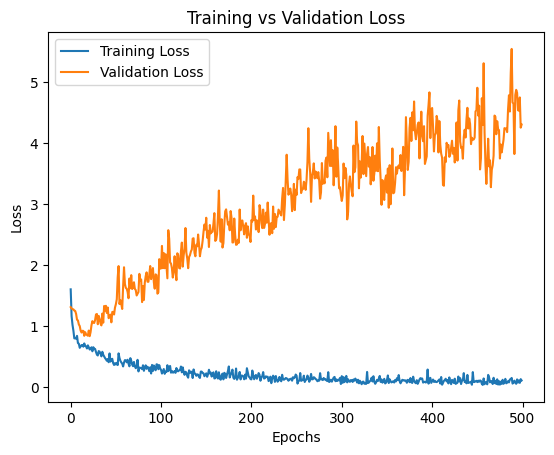

In [5]:
#Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

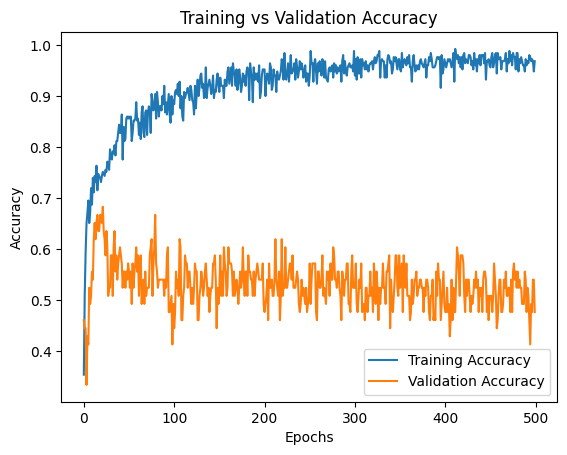

In [6]:
#Training Accuracy vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [7]:
pred_probs_test = model.predict(X_test)
pred_classes_test = np.argmax(pred_probs_test, axis=1) + 1

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


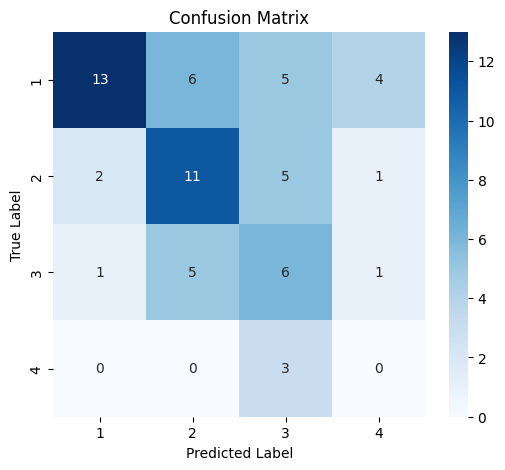

In [8]:
#Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(Y_test, pred_classes_test)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
print(classification_report(Y_test, pred_classes_test))

              precision    recall  f1-score   support

           1       0.81      0.46      0.59        28
           2       0.50      0.58      0.54        19
           3       0.32      0.46      0.38        13
           4       0.00      0.00      0.00         3

    accuracy                           0.48        63
   macro avg       0.41      0.38      0.38        63
weighted avg       0.58      0.48      0.50        63



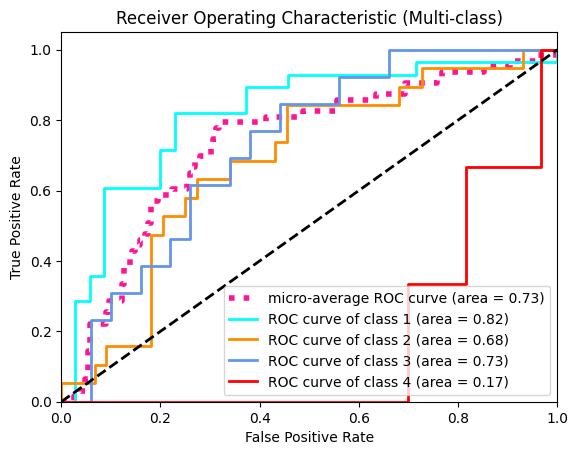

In [11]:
classes = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), pred_probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Adjust or extend for more classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()

# Avoiding Overfitting

In [12]:
# Training Accuracy: 100, Validation Accuracy: 57, Validation Weighted Average: 76

#Weighted vaerage computes the metric for each class, but then it averages them by 
#taking into account the support (i.e., the number of true instances for each class)

early_stop = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),

    keras.layers.Dense(32, activation='relu'),
    Dropout(0.3),

    keras.layers.Dense(Y_train_cat.shape[1], activation='softmax')
])
# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), #RMS Prop can be better for small dataset
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train_cat, 
                    validation_data=(X_test, Y_test_cat), 
                    epochs=500,  # More epochs
                    batch_size=32,
                    callbacks=[early_stop]
                    )

Epoch 1/500


/Applications/miniconda3/envs/EDSseminar/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2742 - loss: 1.3933 - val_accuracy: 0.4444 - val_loss: 1.3162
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3976 - loss: 1.3226 - val_accuracy: 0.4444 - val_loss: 1.2835
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4051 - loss: 1.3068 - val_accuracy: 0.4444 - val_loss: 1.2626
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3740 - loss: 1.3183 - val_accuracy: 0.4444 - val_loss: 1.2438
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4307 - loss: 1.2627 - val_accuracy: 0.4444 - val_loss: 1.2186
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3818 - loss: 1.2417 - val_accuracy: 0.4444 - val_loss: 1.1897
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4097 - loss: 1.2599 - val_accuracy: 0.4444 - val_loss: 1.1633
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4724 - loss: 1.1931 - val_accuracy: 0.4762 - val_loss: 1.1420
Epoch 9/500


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7643 - loss: 0.6536 - val_accuracy: 0.7619 - val_loss: 0.7595
Epoch 53/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6942 - loss: 0.7521 - val_accuracy: 0.7619 - val_loss: 0.7514
Epoch 54/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6645 - loss: 0.8240 - val_accuracy: 0.7619 - val_loss: 0.7442
Epoch 55/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6908 - loss: 0.7613 - val_accuracy: 0.7619 - val_loss: 0.7573
Epoch 56/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7267 - loss: 0.7619 - val_accuracy: 0.7143 - val_loss: 0.7885
Epoch 57/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7102 - loss: 0.7051 - val_accuracy: 0.7778 - val_loss: 0.7395
Epoch 58/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7291 - loss: 0.7465 - val_accuracy: 0.7619 - val_loss: 0.7335
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 0.6947 - val_accuracy: 0.7778 - val_loss: 0.7338
Epoch

In [23]:
pred_probs_test = model.predict(X_test)
pred_classes_test = np.argmax(pred_probs_test, axis=1) + 1

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/stepWARNING:tensorflow:6 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x15a2a37e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


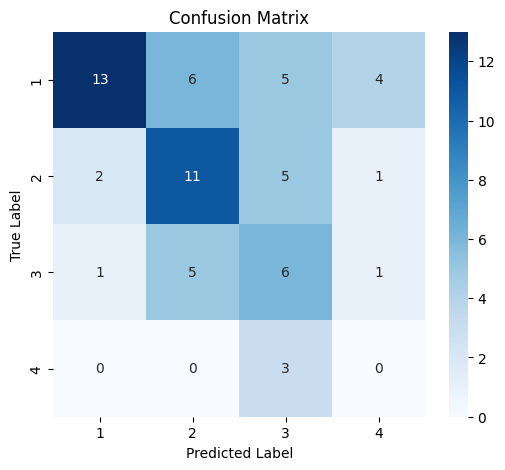

In [13]:
#Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(Y_test, pred_classes_test)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

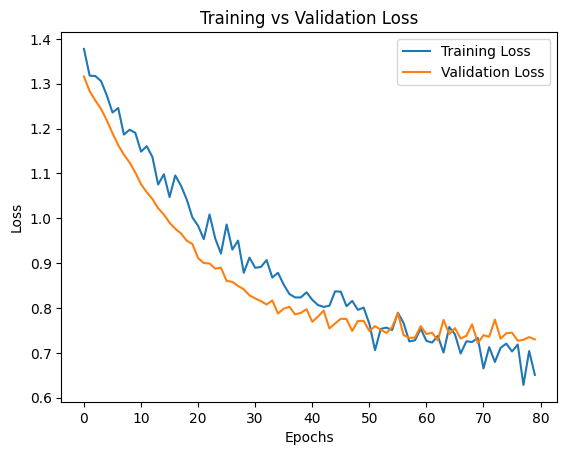

In [14]:
#Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

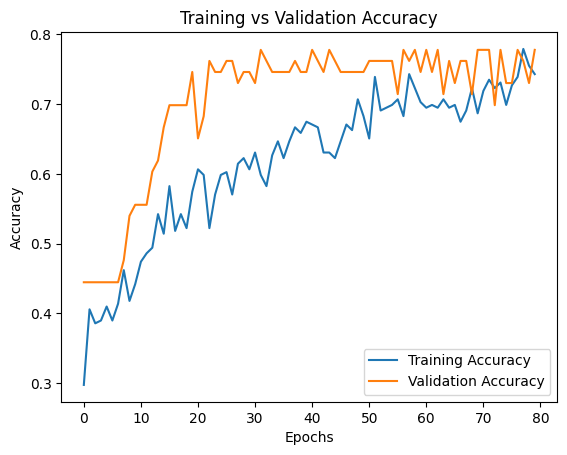

In [15]:
#Training Accuracy vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [16]:
print(classification_report(Y_test, pred_classes_test))

              precision    recall  f1-score   support

           1       0.81      0.46      0.59        28
           2       0.50      0.58      0.54        19
           3       0.32      0.46      0.38        13
           4       0.00      0.00      0.00         3

    accuracy                           0.48        63
   macro avg       0.41      0.38      0.38        63
weighted avg       0.58      0.48      0.50        63



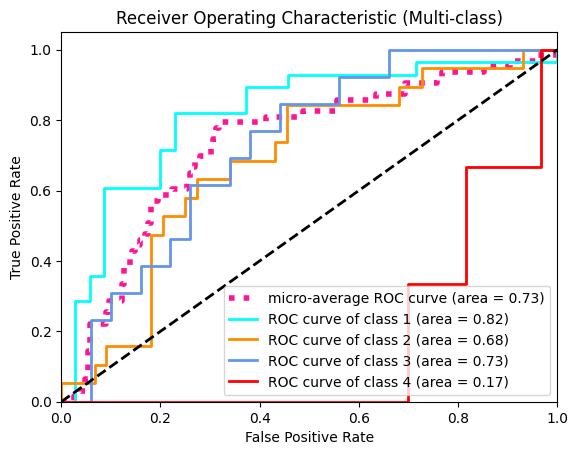

In [17]:
classes = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = Y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], pred_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), pred_probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Adjust or extend for more classes
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()